<a href="https://colab.research.google.com/github/AdhamSalih/DeepBallTAU/blob/master/ProjectDeepforBallDetWithRelax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Project - Training Deep Network for ball detection with pytorch**
This Project includes two models for Ball Detection - with Relaxed data
1. DeepBall
2. DeepBall with classification layer

# General setup

Mounting the drive

In [0]:
from google.colab import drive, files
drive.mount("/content/drive")
folderpath = '/content/drive/My Drive/DL_TAU2019/Project_300746930_034915504/'


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Installing all the needed lib.

In [0]:
# !pip install torch numpy torchvision matplotlib tabulate
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms, utils, datasets
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
import pickle
import cv2


In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


#Dataset Loading

In [0]:
idx = 0
train_batch = pickle.load( open( folderpath + "Dataset/train/train_batch_file" + str(idx)+".h5", "rb" ) )
Images = train_batch[0]
Labels = train_batch[1][:,0]
while idx < 5:
  idx += 1
  train_batch = pickle.load( open( folderpath + "Dataset/train/train_batch_file"+str(idx)+".h5", "rb" ) )
  Images = torch.cat((Images,train_batch[0]))
  Labels = torch.cat((Labels,train_batch[1][:,0]))
  print(idx)
del train_batch

train_dataset = TensorDataset(Images,Labels)

del Images,Labels

1
2
3
4
5


In [0]:
batch_size = 50
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
print(len(train_dataloader))

240


In [0]:
idx = 0
train_batch = pickle.load( open( folderpath + "Dataset/test/test_batch_file" + str(idx)+".data", "rb" ) )
Images = train_batch[0]
Labels = train_batch[1][:,0]
while idx < 2:
  idx += 1
  train_batch = pickle.load( open( folderpath + "Dataset/test/test_batch_file"+str(idx)+".data", "rb" ) )
  Images = torch.cat((Images,train_batch[0]))
  Labels = torch.cat((Labels,train_batch[1][:,0]))
  print(idx)
  del train_batch
test_dataset = TensorDataset(Images,Labels)
del Images,Labels

1
2


In [0]:

test_dataloader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)
print(len(test_dataloader))

120


In [0]:
# uncomment for cross-validation

# test_idx = int(len(Images)*0.2)
# val_x, test_x = Images[:test_idx], Images[test_idx:]
# val_y, test_y = Labels[:test_idx], Labels[test_idx:]


# valid_dataset = TensorDataset(val_x,val_y)
# valid_dataloader = DataLoader(valid_dataset,batch_size=batch_size,shuffle=True)
# print(len(valid_dataloader))
# test_dataset = TensorDataset(test_x,test_y)
# test_dataloader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)
# print(len(test_dataloader))
# del Images,Labels

# DeepBall

**Hyperparameters**

In [0]:

inital_lr = 0.001
SGDlr = 0.1
num_epochs = 75 #number of epochs 
toSGD = 1 # after num_epochs/toSGD switch to Adam 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device != "cpu":
  print("GPU is available")
else:
  print("Work on CPU")
BN = True
DP = 0
WD = 0
clip = 0

GPU is available


*Network Classes and Training Functions* 


In [0]:
class DeepBall(nn.Module):
    def __init__(self):
        super(DeepBall, self).__init__()
        # the 1st conv. block 
        self.conv11 = nn.Conv2d(3, 8, 3,stride=2,padding=1)
        self.conv12 = nn.Conv2d(8, 8, 3,stride=1,padding=1) 
        
         # pooling size 2
        self.pool = nn.MaxPool2d(2, 2) 

        # the 2nd conv. block 
        self.conv21 = nn.Conv2d(8, 16, 3,padding=1)
        self.conv22 = nn.Conv2d(16, 16, 3,padding=1)
        
        # the 3rd conv. block 
        self.conv31 = nn.Conv2d(16, 32, 3,padding=1)
        self.conv32 = nn.Conv2d(32, 32, 3,padding=1)
        
        # the 4th conv. block 
        self.conv41 = nn.Conv2d(56, 56, 3,padding=1)
        self.conv42 = nn.Conv2d(56, 2, 3,padding=1)
        
        # Upsampling
        self.ups24 = nn.Upsample(scale_factor=2)
        self.ups34 = nn.Upsample(scale_factor=4)
        
        self.bn11 = nn.BatchNorm2d(8)
        self.bn12 = nn.BatchNorm2d(8)
        self.bn21 = nn.BatchNorm2d(16)
        self.bn22 = nn.BatchNorm2d(16)
        self.bn31 = nn.BatchNorm2d(32)
        self.bn32 = nn.BatchNorm2d(32)
        self.bn41 = nn.BatchNorm2d(56)
        self.bn42 = nn.BatchNorm2d(2)
        
    def forward(self, x):
      # 1st block
      if x.size()[2]!=272 or x.size()[3]!=480:
        x = F.interpolate(x, size=(272,480))
      
      x1 = F.relu(self.bn11(self.conv11(x)))
      x1 = F.relu(self.bn12(self.conv12(x1)))
      x1 = self.pool(x1)
      
      # 2nd Block
      x2 = F.relu(self.bn21(self.conv21(x1)))
      x2 = F.relu(self.bn22(self.conv22(x2)))
      x2 = self.pool(x2)
      
      # 3rd Block
      x3 = F.relu(self.bn31(self.conv31(x2)))
      x3 = F.relu(self.bn32(self.conv32(x3)))
      x3 = self.pool(x3)

      # 4th Block
      x2 = self.ups24(x2)
      x3 = self.ups34(x3)
      x4 = torch.cat([x2,x3,x1],dim=1)
      x4 = F.relu(self.bn41(self.conv41(x4)))
      x4 = F.relu(self.bn42(self.conv42(x4)))  
      
      out = F.log_softmax(x4,dim=1)
      if out.size()[2]!=68 or out.size()[3]!=120:
        out = F.interpolate(out, size=(68,120))
      del x1,x2,x3,x4
      torch.cuda.empty_cache()
      return out

In [0]:
def DeepBallLoss(Pre,Tar,notlogflag = False):
  N_b = Tar.size()[0]
  Ballgt = Tar
  zer = torch.zeros_like(Ballgt)
  N = torch.sum(Ballgt,dim=(1,2)).int()+1
  BGgt = 1 - Tar

  M = torch.sum(BGgt,dim=(1,2)).int()+1
  if notlogflag:
    Pre = torch.log(Pre)
  Ballcm = Pre[:,0,:,:]
  BGcm = Pre[:,1,:,:]

  kernel = np.ones((3,3),np.uint8)
  errorSumPos = torch.zeros_like(N.double())
  for i in range(len(errorSumPos)):

    errorSumPos[i] = torch.sum(torch.mul(Ballcm[i].double(),Ballgt[i].double()))
  Lpos = torch.sum(torch.addcdiv(torch.zeros_like(N).double(),1,errorSumPos.double(),N.double()))

  errorSumNeg = torch.zeros_like(N.double())
  for i in range(len(errorSumNeg)):
      if (torch.sum(BGgt[i]).cpu().numpy() == BGgt[i].shape[0]*BGgt[i].shape[1]):

          errorSumNeg[i] = torch.sum(BGcm[i].double())
      else:

          erosion = cv2.erode(BGgt[i].cpu().numpy(),kernel,iterations = 1)
          errorSumNeg[i] = torch.sum(torch.mul(BGcm[i].double(),torch.from_numpy(erosion.copy()).to(device).double()))
  Lneg = torch.sum(torch.addcdiv(torch.zeros_like(M).double(),1,errorSumNeg.double(),M.double()))

  del Ballgt,BGgt,Ballcm,BGcm
  torch.cuda.empty_cache()

  return -Lpos-1*Lneg


In [0]:
# for debugg
with torch.no_grad():
  model = DeepBall()
  model.eval()
  x = torch.randn([16,3,272,480])
  yt = torch.rand([16,68,120])
  yt = yt.int()
  print(x.size())
  y =  model(x)
  print(y.size())
  loss = DeepBallLoss(y, yt)
  print(loss)
# del x, y, model,loss

torch.Size([16, 3, 272, 480])
torch.Size([16, 2, 68, 120])
tensor(11.1121, dtype=torch.float64)


Training function

In [0]:
def run_epochDeepBall(model, data,optimizer=False, is_train=False, clip=0):
  """Runs the model on the given data."""
  if is_train:
    model.train()
  else:
    model.eval()
  costs = 0.0
  iters = 0
  for iteration, (images, labels) in enumerate(data):
    images, labels = images.to(device), labels.to(device)
    model.zero_grad()
    output = model(images.float()/255.0)
    loss = DeepBallLoss(output, labels) 
    costs += loss.item()
    iters += 1
    if is_train:
      loss.backward()
      if clip>0:
        nn.utils.clip_grad_norm_(model.parameters(), clip)
      optimizer.step()
  del loss
  return (costs / iters)

## ***Training DeepBall***

++++++++++++++++++++++++++ Training ++++++++++++++++++++++++++
>> epoch: 1, train_loss: 22.426,  test_loss: 21.111
>> epoch: 2, train_loss: 17.948,  test_loss: 16.388
>> epoch: 3, train_loss: 16.847,  test_loss: 16.340
>> epoch: 4, train_loss: 13.170,  test_loss: 13.135
>> epoch: 5, train_loss: 12.325,  test_loss: 12.260
>> epoch: 6, train_loss: 10.973,  test_loss: 11.218
>> epoch: 7, train_loss: 8.447,  test_loss: 8.387
>> epoch: 8, train_loss: 7.979,  test_loss: 8.104
>> epoch: 9, train_loss: 6.994,  test_loss: 7.145
>> epoch: 10, train_loss: 6.483,  test_loss: 6.639
>> epoch: 11, train_loss: 5.606,  test_loss: 5.846
>> epoch: 12, train_loss: 5.281,  test_loss: 5.658
>> epoch: 13, train_loss: 4.866,  test_loss: 5.396
>> epoch: 14, train_loss: 4.471,  test_loss: 4.837
>> epoch: 15, train_loss: 4.195,  test_loss: 4.399
------------------ best model saved ---------------------------
>> epoch: 16, train_loss: 3.978,  test_loss: 4.439
>> epoch: 17, train_loss: 3.849,  test_loss: 4.323
>> 

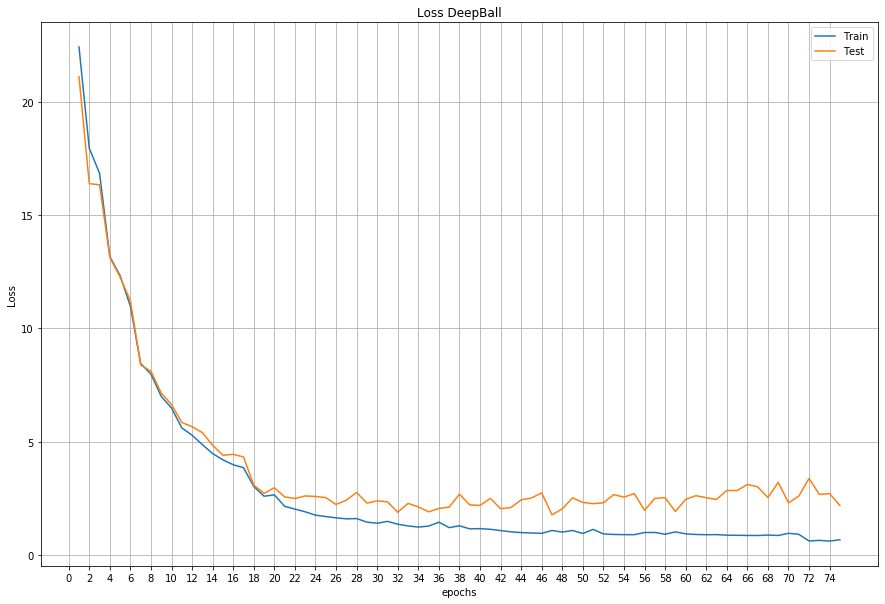

In [0]:
model = DeepBall().to(device)
# model.apply(weights_init)
model.to(device)
# optimizer = torch.optim.SGD(model.parameters(),lr = SGDlr,weight_decay=WD)
optimizer = torch.optim.Adam(model.parameters(),lr = inital_lr,weight_decay=WD)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.8)
ValidLoss = 10000000
flag = 0
cntr = 0
TrainP = []
ValidP = []
TestP = []
print("++++++++++++++++++++++++++ Training ++++++++++++++++++++++++++")
for epoch in range(num_epochs):
  if epoch == int(num_epochs/toSGD):
      print("++++++++++++++++++++++++++ Switching to Adam++++++++++++++++++++++++++")
      del optimizer
      optimizer = torch.optim.Adam(model.parameters(),lr = inital_lr)
  _ = run_epochDeepBall(model, train_dataloader,optimizer, True,clip)
  scheduler.step()
  with torch.no_grad():
    train_p = run_epochDeepBall(model, train_dataloader,optimizer, False) # presents without the dropout
    # valid_p = run_epoch(model, valid_dataloader,optimizer) # uncomment for cross-validation
    test_p = run_epochDeepBall(model, test_dataloader,optimizer)
  valid_p = test_p # comment for cross-validation
  # test_p = train_p
  TrainP.append(train_p)
  ValidP.append(valid_p)
  TestP.append(test_p)
  if ValidLoss > valid_p:
    torch.save(model.state_dict(), folderpath+'DeepBallmodel_r.pt')
    TrainLoss = train_p
    ValidLoss = valid_p
    TestLoss = test_p
    cntr = 0
    if flag == 1:
      flag = 0
  elif flag == 0:
    flag = 1
    print('------------------ best model saved ---------------------------')
  else:
    cntr += 1
    if cntr == int(num_epochs):
      num_epochs = epoch + 1
      print('-------------- over-training !!! Stop Training --------------------')
      break
    
  print('>> epoch: {}, train_loss: {:.3f},  test_loss: {:.3f}'.format(epoch+1, train_p,test_p))           


print("++++++++++++++++++++++++++ Done! ++++++++++++++++++++++++++")
plt.figure(figsize=(15,10))
plt.plot(range(1,num_epochs+1),TrainP, label = 'Train')
plt.plot(range(1,num_epochs+1),TestP, label = 'Test')
plt.xticks(np.arange(0, num_epochs+1, 2.0))
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()
plt.title('Loss DeepBall')
plt.grid(True)
plt.show()
DeepBallmodel = model
del ValidLoss, cntr, TrainP, ValidP, TestP
del model,optimizer

Random check

(4, 36) (0, 0) 0.9854578


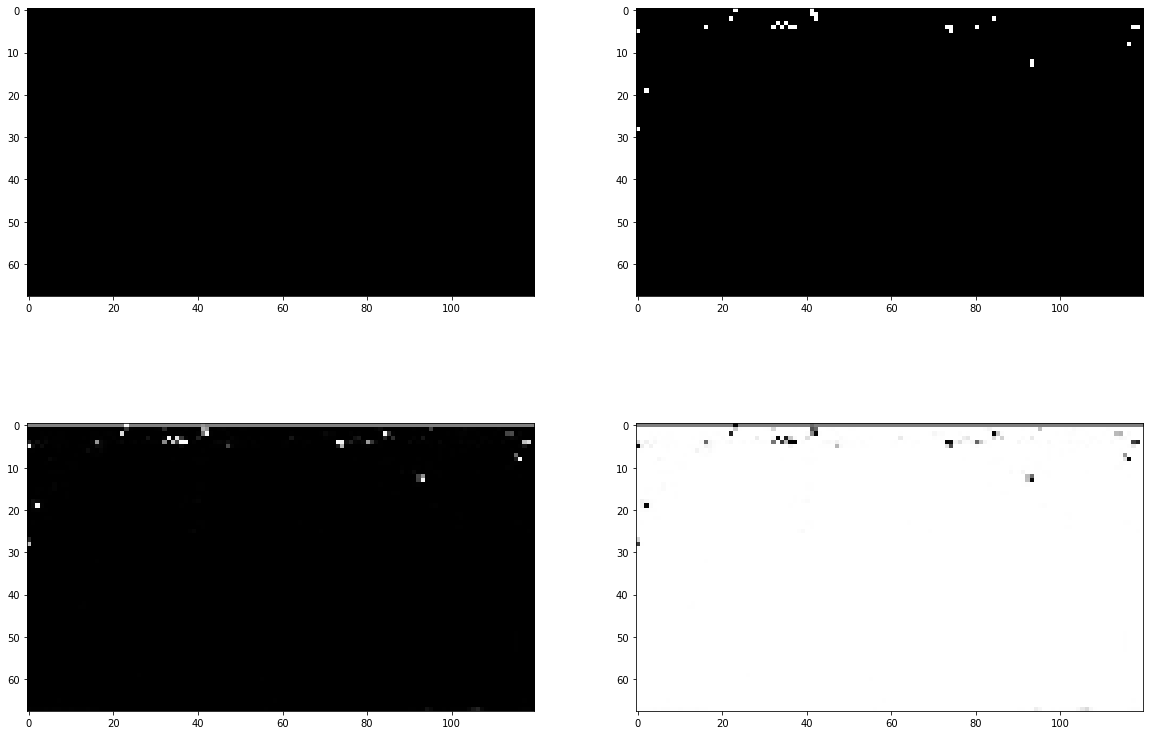

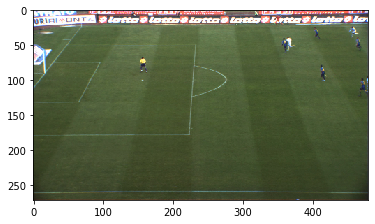

In [0]:
# DeepBallmodel = DeepBall(BN).to(device)
DeepBallmodel.load_state_dict(torch.load(folderpath+'DeepBallmodel_r.pt')) #load the last checkpoint
with torch.no_grad():
  DeepBallmodel.eval()
  index = 10
  img, label =  test_dataset[400]

  img = (img.view(1,3,272,480)).to(device)
  Mask= DeepBallmodel(img.float()/255.0)
  Mask = torch.exp(Mask)
a = (Mask[0][0].cpu().numpy())
pos = np.unravel_index(np.argmax(a), a.shape)
real_pos = np.unravel_index(np.argmax(label.cpu().numpy()), label.cpu().numpy().shape)
print(pos, real_pos, a.max())


plt.figure(figsize=(20,14))
plt.subplot(2,2,1)
img = img.to('cpu')
img = img.view(3,272,480)

plt.imshow(label.cpu(),cmap='gray')
plt.subplot(2,2,2)
om = 1-torch.argmax(Mask.squeeze(), dim=0).detach().cpu().numpy()
Mask = Mask.cpu()
plt.imshow(om, cmap='gray')
plt.subplot(2,2,3)
plt.imshow(Mask[0][0], cmap='gray')
plt.subplot(2,2,4)
plt.imshow(Mask[0][1], cmap='gray')
plt.show()
plt.figure()
plt.imshow(np.transpose(img.numpy(),(1,2,0)))
plt.show()

# DeepBall with a classification layer

In [0]:
class DeepBallClass(nn.Module):
    def __init__(self, BN = True,DP = 0):
        super(DeepBallClass, self).__init__()
        self.BN = BN
        self.DP = DP
        # the 1st conv. block 
        self.conv11 = nn.Conv2d(3, 8, 3,stride=2,padding=1)
        
        self.conv12 = nn.Conv2d(8, 8, 3,stride=1,padding=1) 
        
         # pooling size 2
        self.pool = nn.MaxPool2d(2, 2) 

        # the 2nd conv. block 
        self.conv21 = nn.Conv2d(8, 16, 3,padding=1)
        
        self.conv22 = nn.Conv2d(16, 16, 3,padding=1)
        
        # the 3rd conv. block 
        self.conv31 = nn.Conv2d(16, 32, 3,padding=1)
        
        self.conv32 = nn.Conv2d(32, 32, 3,padding=1)
        
        # the 4th conv. block 
        self.conv41 = nn.Conv2d(56, 56, 3,padding=1)
        
        self.conv42 = nn.Conv2d(56, 2, 3,padding=1)
        
        # Upsampling
        self.ups24 = nn.Upsample(scale_factor=2)
        self.ups34 = nn.Upsample(scale_factor=4)
        if BN:
          self.bn11 = nn.BatchNorm2d(8)
          self.bn12 = nn.BatchNorm2d(8)
          self.bn21 = nn.BatchNorm2d(16)
          self.bn22 = nn.BatchNorm2d(16)
          self.bn31 = nn.BatchNorm2d(32)
          self.bn32 = nn.BatchNorm2d(32)
          self.bn41 = nn.BatchNorm2d(56)
          self.bn42 = nn.BatchNorm2d(2)
        if DP > 0:
          self.dropout2d = nn.Dropout2d(p=DP)
        
        self.fc1 = nn.Linear(32*30*17,200)
        self.fc2 = nn.Linear(200,1)
        # self.sm = nn.Sigmoid()

    def forward(self, x):
      # 1st block
      BN = self.BN
      DP = self.DP
      if x.size()[2]!=272 or x.size()[3]!=480:
        x = F.interpolate(x, size=(272,480))
      if BN:
        x1 = F.relu(self.bn11(self.conv11(x)))
        if DP > 0:
          x1 = self.dropout2d(x1)
        x1 = F.relu(self.bn12(self.conv12(x1)))
        if DP > 0:
          x1 = self.dropout2d(x1)
      else:
        x1 = F.relu(self.conv11(x))
        if DP > 0:
          x1 = self.dropout2d(x1)
        x1 = F.relu(self.conv12(x1))
        if DP > 0:
          x1 = self.dropout2d(x1)
      x1 = self.pool(x1)
      
      # 2nd Block
      if BN:
        x2 = F.relu(self.bn21(self.conv21(x1)))
        if DP > 0:
          x2 = self.dropout2d(x2)
        x2 = F.relu(self.bn22(self.conv22(x2)))
        if DP > 0:
          x2 = self.dropout2d(x2)
      else:
        x2 = F.relu(self.conv21(x1))
        if DP > 0:
          x2 = self.dropout2d(x2)
        x2 = F.relu(self.conv22(x2))
        if DP > 0:
          x2 = self.dropout2d(x2)
      
      # print(x2.size())
      x2 = self.pool(x2)
      
      # 3rd Block
      if BN:
        x3 = F.relu(self.bn31(self.conv31(x2)))
        if DP > 0:
          x3 = self.dropout2d(x3)
        x3 = F.relu(self.bn32(self.conv32(x3)))
        if DP > 0:
          x3 = self.dropout2d(x3)
      else:
        x3 = F.relu(self.conv31(x2))
        if DP > 0:
          x3 = self.dropout2d(x3)
        x3 = F.relu(self.conv32(x3))
        if DP > 0:
          x3 = self.dropout2d(x3)
      # print(x3.size())
      x3 = self.pool(x3)
      # print(x3.size())
      # 4th Block
      x2 = self.ups24(x2)
      x3u = self.ups34(x3)
      # print(x3up.size(),x2up.size(),x1.size())
      x4 = torch.cat([x2,x3u,x1],dim=1)
      if BN:
        x4 = F.relu(self.bn41(self.conv41(x4)))
        if DP > 0:
          x4 = self.dropout2d(x4)
        x4 = F.relu(self.bn42(self.conv42(x4)))
        if DP > 0:
          x4 = self.dropout2d(x4)
      else:
        x4 = F.relu(self.conv41(x4))
        if DP > 0:
          x4 = self.dropout2d(x4)
        x4 = F.relu(self.conv42(x4))
        if DP > 0:
          x4 = self.dropout2d(x4)
        
      out = F.log_softmax(x4,dim=1)
      x3 = x3.view(-1,32*30*17)
      x3 = self.fc2(F.relu(self.fc1(x3)))
      Cout = torch.sigmoid(x3)
      if out.size()[2]!=68 or out.size()[3]!=120:
        out = F.interpolate(out, size=(68,120))
      # print(out.size())
      del x1,x2,x3,x4
      torch.cuda.empty_cache()
      return out,Cout

In [0]:
def DeepBallCalssLoss(Cout,Pre,Tar,notlogflag = False):
  N_b = Tar.size()[0]
  Ballgt = Tar
  N = torch.sum(Ballgt,dim=(1,2)).int()+1
  BGgt = 1 - Tar
  # idx = torch.where(BGgt==0)
  Targets = torch.sum(Ballgt,dim=(1,2)).float()
  
  Lclass = F.binary_cross_entropy(Cout.view(N_b),Targets)

  M = torch.sum(BGgt,dim=(1,2)).int()+1
  if notlogflag:
    Pre = torch.log(Pre)
  Ballcm = Pre[:,0,:,:]
  BGcm = Pre[:,1,:,:]
  Lpos = torch.sum(torch.mul(Ballcm.double(),Ballgt.double()),dim=(1,2))

  Lpos = torch.sum(torch.div(Lpos.double(),N.double()))

  kernel = np.ones((3,3),np.uint8)
  errorSumNeg = torch.zeros_like(N.double())
  for i in range(len(errorSumNeg)):
      if (torch.sum(BGgt[i]).cpu().numpy() == BGgt[i].shape[0]*BGgt[i].shape[1]):

          errorSumNeg[i] = torch.sum(BGcm[i].double())
      else:

          erosion = cv2.erode(BGgt[i].cpu().numpy(),kernel,iterations = 1)
          errorSumNeg[i] = torch.sum(torch.mul(BGcm[i].double(),torch.from_numpy(erosion.copy()).to(device).double()))
  Lneg = torch.sum(torch.div(errorSumNeg.double(),M.double()))


  del Ballgt,BGgt,Ballcm,BGcm
  torch.cuda.empty_cache()

  return 0.8*(-Lpos-1*Lneg)+0.2*Lclass

## Training proc. with class

In [0]:
def run_epochDeepBallclass(model, data,optimizer=False, is_train=False, clip=0):
  """Runs the model on the given data."""
  if is_train:
    model.train()
  else:
    model.eval()
  costs = 0.0
  iters = 0
  for iteration, (images, labels) in enumerate(data):
    images, labels = images.to(device), labels.to(device)
    model.zero_grad()
    output, c = model(images.float()/255.0)
    loss = DeepBallCalssLoss(c,output, labels) 
    costs += loss.item()
    iters += 1
    if is_train:
      loss.backward()
      if clip>0:
        nn.utils.clip_grad_norm_(model.parameters(), clip)
      optimizer.step()
  del loss
  return (costs / iters)

Main Training with class

++++++++++++++++++++++++++ Training ++++++++++++++++++++++++++
>> epoch: 1, train_loss: 18.491,  test_loss: 16.879
>> epoch: 2, train_loss: 15.964,  test_loss: 14.717
>> epoch: 3, train_loss: 13.224,  test_loss: 12.190
>> epoch: 4, train_loss: 11.690,  test_loss: 10.800
>> epoch: 5, train_loss: 10.402,  test_loss: 9.848
>> epoch: 6, train_loss: 9.100,  test_loss: 8.498
>> epoch: 7, train_loss: 8.234,  test_loss: 7.869
>> epoch: 8, train_loss: 7.297,  test_loss: 6.924
>> epoch: 9, train_loss: 6.556,  test_loss: 6.552
>> epoch: 10, train_loss: 5.974,  test_loss: 5.889
>> epoch: 11, train_loss: 5.640,  test_loss: 5.650
>> epoch: 12, train_loss: 4.897,  test_loss: 4.932
>> epoch: 13, train_loss: 4.357,  test_loss: 4.752
>> epoch: 14, train_loss: 3.978,  test_loss: 4.497
------------------ best model saved ---------------------------
>> epoch: 15, train_loss: 3.861,  test_loss: 4.657
>> epoch: 16, train_loss: 3.581,  test_loss: 4.386
>> epoch: 17, train_loss: 3.199,  test_loss: 4.195
>> epo

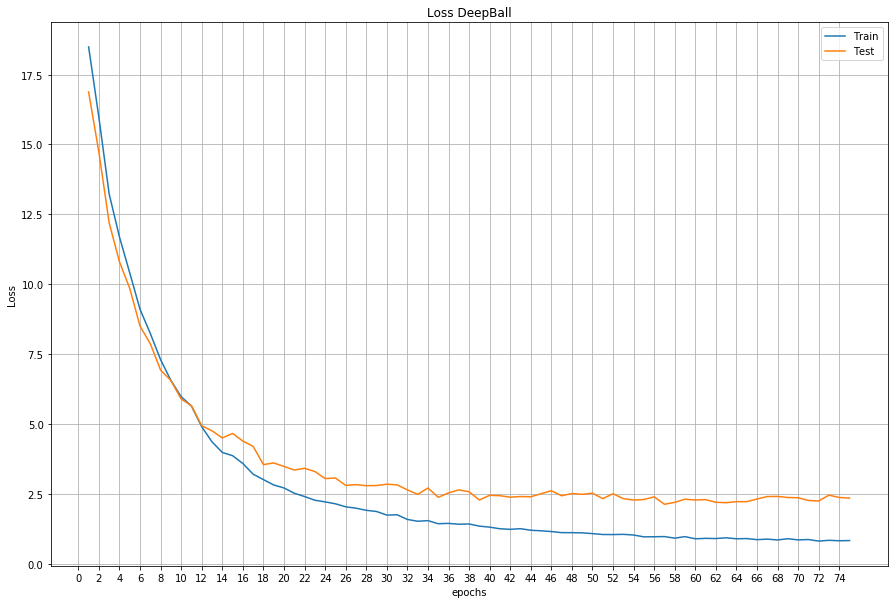

In [0]:
model = DeepBallClass(DP=0.2).to(device)
# model.apply(weights_init)
model.to(device)
# optimizer = torch.optim.SGD(model.parameters(),lr = SGDlr,weight_decay=WD)
optimizer = torch.optim.Adam(model.parameters(),lr = inital_lr,weight_decay=WD)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
ValidLoss = 10000000
flag = 0
cntr = 0
TrainP = []
ValidP = []
TestP = []
# num_epochs = 75
print("++++++++++++++++++++++++++ Training ++++++++++++++++++++++++++")
for epoch in range(num_epochs):
  if epoch == int(num_epochs/toSGD):
      print("++++++++++++++++++++++++++ Switching to Adam++++++++++++++++++++++++++")
      del optimizer
      optimizer = torch.optim.Adam(model.parameters(),lr = inital_lr)
  _ = run_epochDeepBallclass(model, train_dataloader,optimizer, True,clip)
  scheduler.step()
  with torch.no_grad():
    train_p = run_epochDeepBallclass(model, train_dataloader,optimizer, False) # presents without the dropout # uncomment for cross-validation
    # valid_p = run_epoch(model, valid_dataloader,optimizer)
    test_p = run_epochDeepBallclass(model, test_dataloader,optimizer)
  valid_p = test_p  # comment for cross-validation
  # test_p = train_p
  TrainP.append(train_p)
  ValidP.append(valid_p)
  TestP.append(test_p)
  if ValidLoss > valid_p:
    torch.save(model.state_dict(), folderpath+'DeepBallclassmodel_r.pt')
    TrainLoss = train_p
    ValidLoss = valid_p
    TestLoss = test_p
    cntr = 0
    if flag == 1:
      flag = 0
  elif flag == 0:
    flag = 1
    print('------------------ best model saved ---------------------------')
  else:
    cntr += 1
    if cntr == int(num_epochs):
      num_epochs = epoch + 1
      print('-------------- over-training !!! Stop Training --------------------')
      break
    
  print('>> epoch: {}, train_loss: {:.3f},  test_loss: {:.3f}'.format(epoch+1, train_p,test_p))           

# print('Test loss: {:.2f}'.format(TestPrepGRUdrop))
print("++++++++++++++++++++++++++ Done! ++++++++++++++++++++++++++")
plt.figure(figsize=(15,10))
plt.plot(range(1,num_epochs+1),TrainP, label = 'Train')
# plt.plot(range(1,num_epochs+1),ValidP, label = 'Validation') # uncomment for cross-validation
plt.plot(range(1,num_epochs+1),TestP, label = 'Test')
plt.xticks(np.arange(0, num_epochs+1, 2.0))
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()
plt.title('Loss DeepBall')
plt.grid(True)
plt.show()
DeepBallClassmodel = model
del ValidLoss, cntr, TrainP, ValidP, TestP
del model,optimizer

0.9582387804985046
(11, 29) (11, 29) 0.9993465


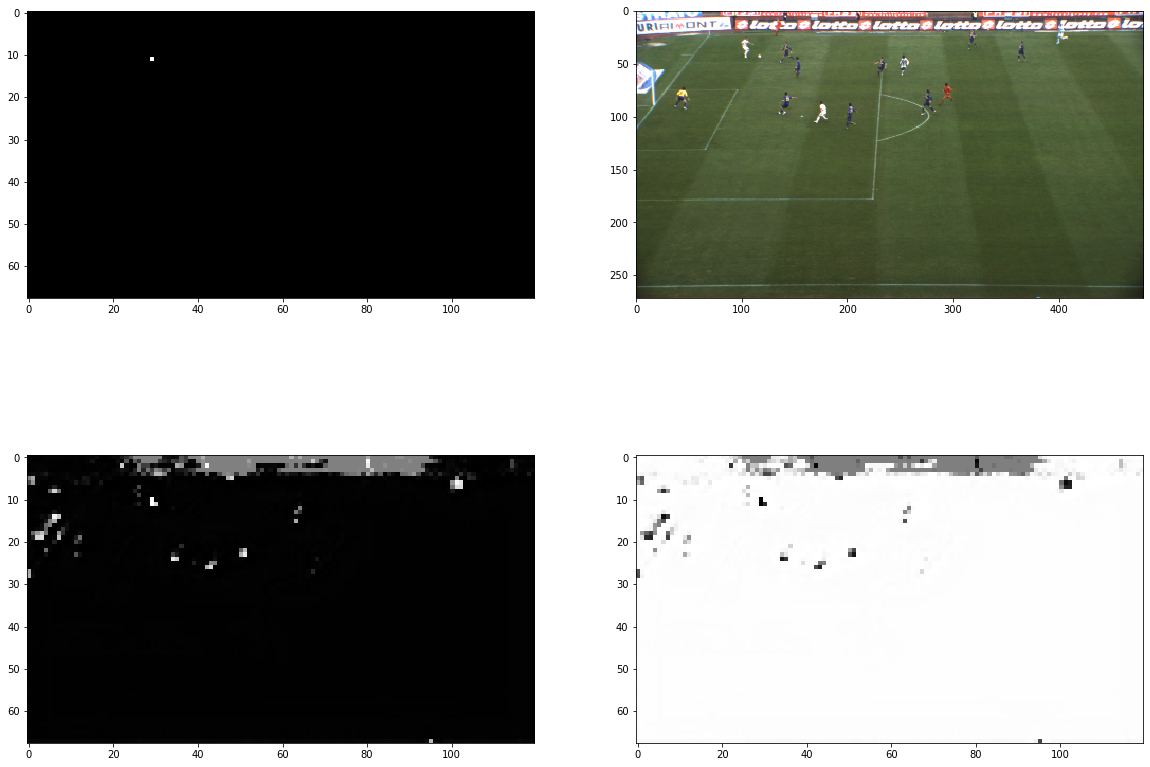

In [0]:
DeepBallClassmodel = DeepBallClass(DP = 0.2).to(device)
DeepBallClassmodel.load_state_dict(torch.load(folderpath+'DeepBallclassmodel_r.pt')) #load the last checkpoint
with torch.no_grad():
  DeepBallClassmodel.eval()
  index = 540
  img, label =  test_dataset[500]
  # img, label = iter(dataloader).next()
  img = (img.view(1,3,272,480)).to(device)
  Mask, Cout= DeepBallClassmodel(img.float()/255.0)
  Mask = torch.exp(Mask)
# print(label.size())
print(Cout.item())
a = Mask[0][0].cpu().numpy()
pos = np.unravel_index(np.argmax(a, axis=None), a.shape)
real_pos = np.unravel_index(np.argmax(label.cpu().numpy(), axis=None), label.cpu().numpy().shape)
print(pos, real_pos, a.max())
plt.figure(figsize=(20,15))
plt.subplot(2,2,1)
img = img.to('cpu')
img = img.view(3,272,480)
# plt.imshow(np.transpose(img.numpy(),(1,2,0)))
plt.imshow(label.cpu(),cmap='gray')
plt.subplot(2,2,2)
om = 1-torch.argmax(Mask.squeeze(), dim=0).detach().cpu().numpy()
Mask = Mask.cpu()
plt.imshow(np.transpose(img.numpy(),(1,2,0)))
plt.subplot(2,2,3)
plt.imshow(Mask[0][0], cmap='gray')
plt.subplot(2,2,4)
plt.imshow(Mask[0][1], cmap='gray')
plt.show()
